In [110]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier





In [111]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [112]:
# Function to arrange the columns in the order specified
def arrange_cols(data, cols):
    df = pd.DataFrame()
    for i in cols:
        df = pd.concat([df, data[i]], axis=1)
    return df

# Function to one-hot encode categorical variables
def encode_data(cat_cols, data):
    cat_data = data[cat_cols]
    encoded_cols = pd.get_dummies(cat_data, prefix=cat_cols)
    temp = data.drop(cat_cols, axis=1)
    temp = pd.concat([temp, encoded_cols], axis=1)
    return temp.fillna(0)

In [113]:

# Load train and test data
train_data = pd.read_csv('train[1].csv')
test_data = pd.read_csv('test[1].csv')
train_ids = train_data['id']
test_ids = test_data['id']
del train_data['id']
del test_data['id']

In [119]:
train_data.head()
train_data.describe()


,age,ccontact,lcdays,pcontact,employment,cprice,cconf,euri3,employees,outcome
count,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000
mean,40.080296,2.574867,962.323124,0.170823,0.081249,93.574302,-40.496743,3.622575,5167.135174,0.111304
std,10.426239,2.780901,187.277267,0.486648,1.572366,0.579193,4.642811,1.733652,72.072751,0.314513
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


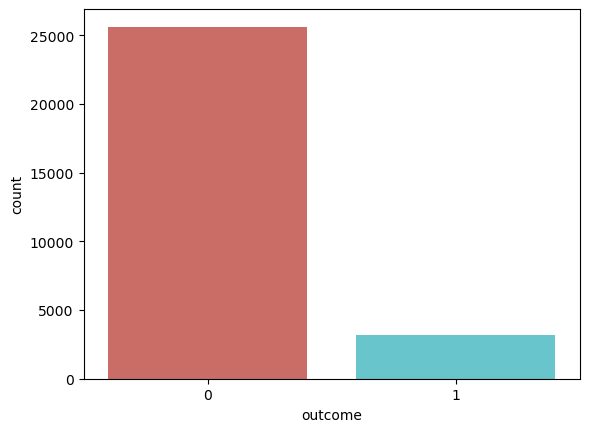

<Axes: >

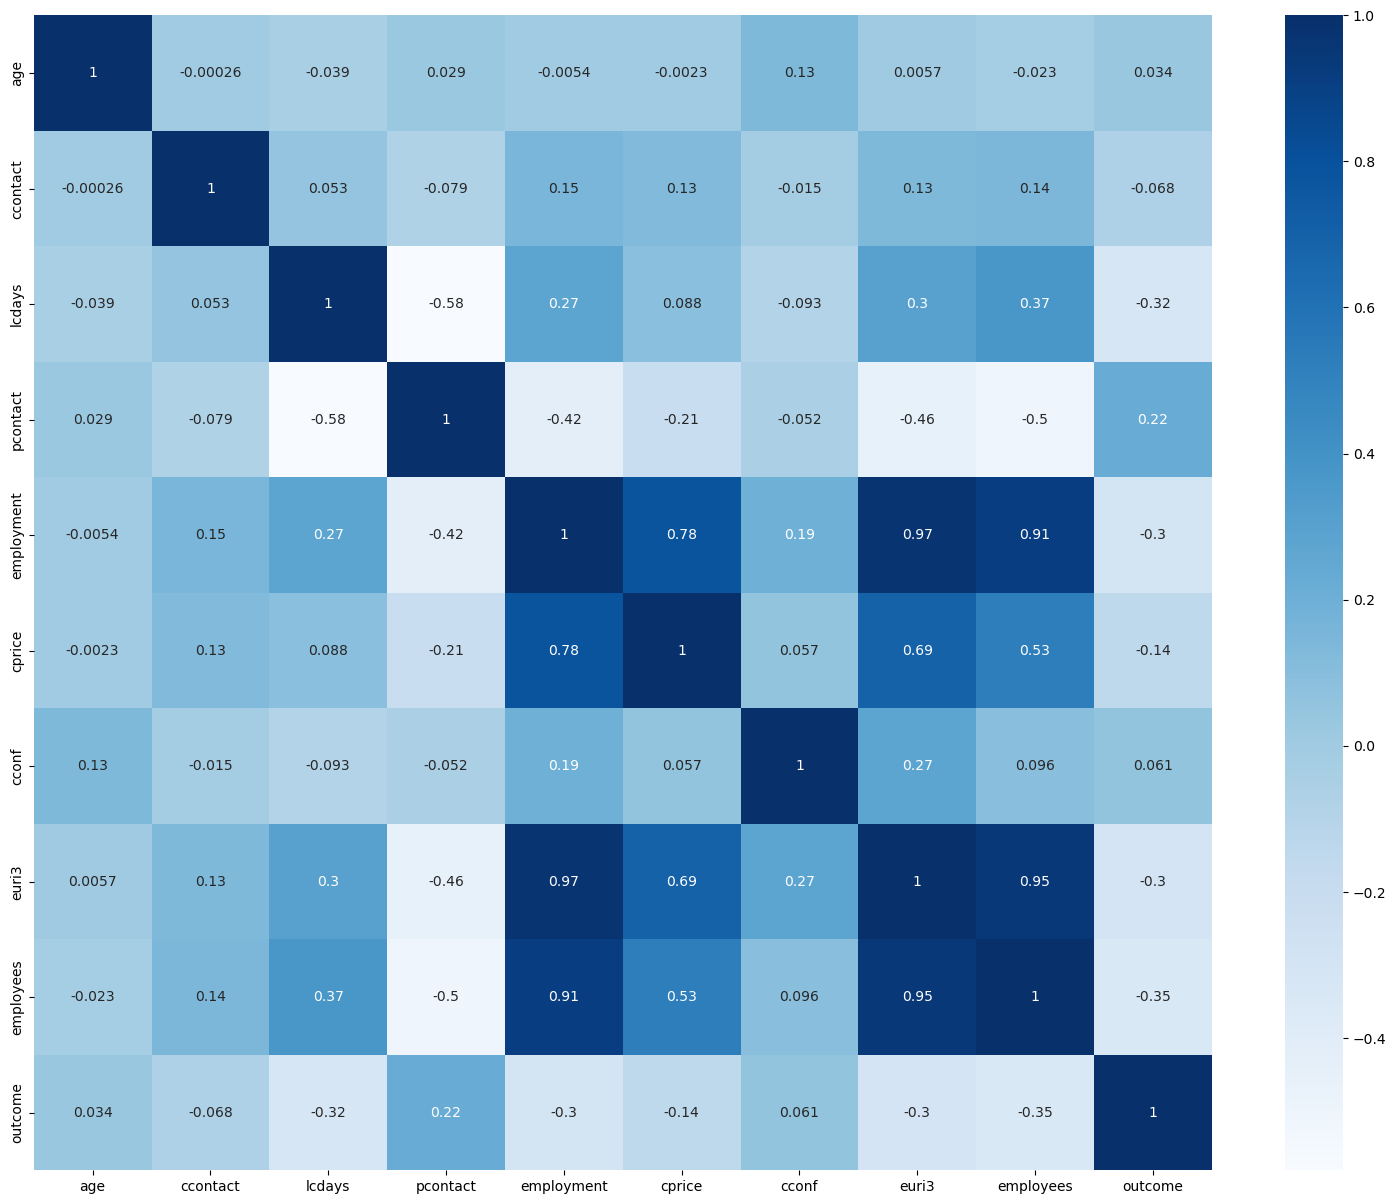

In [118]:

sns.countplot(x ='outcome', data=train_data, palette='hls')
plt.show()

f = plt.figure(figsize=(19, 15))
corr = train_data.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

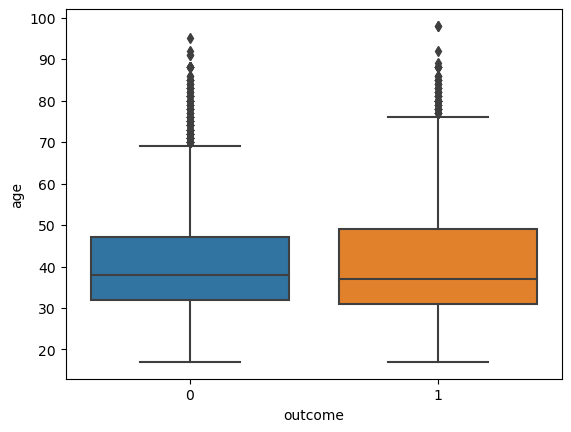

In [120]:
# Boxplot of age by outcome
sns.boxplot(x='outcome', y='age', data=train_data)
plt.show()

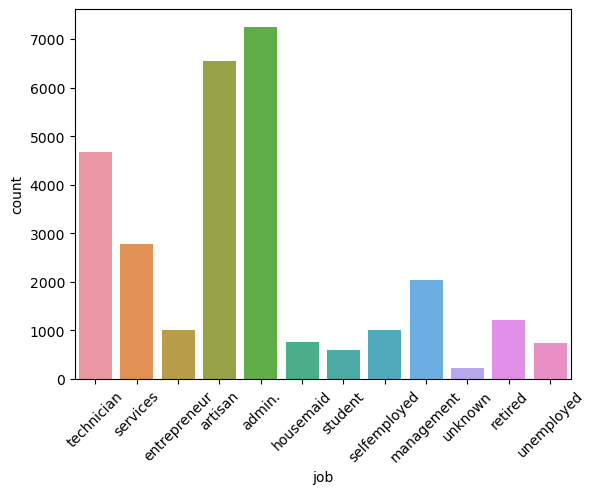

In [121]:
sns.countplot(x='job', data=train_data)
plt.xticks(rotation=45)
plt.show()

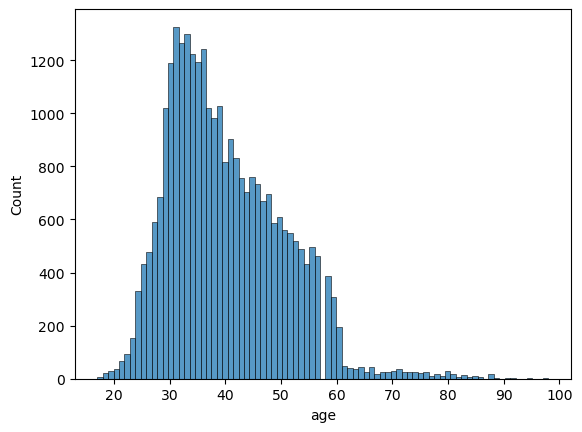

In [122]:
# Distribution of age
sns.histplot(x='age', data=train_data, kde=False)
plt.show()

In [93]:
# Fill missing values with median and mode
X = train_data.drop(['outcome'], axis=1)
X

,age,job,civil,edu,credit,hloan,ploan,ctype,month,day,ccontact,lcdays,pcontact,presult,employment,cprice,cconf,euri3,employees
0,32,technician,married,university,no,yes,no,cellular,jul,thu,7,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1
1,27,services,single,9K,no,no,no,telephone,may,mon,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,57,services,divorced,unknown,no,no,no,cellular,may,fri,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
3,42,entrepreneur,married,university,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0
4,49,technician,married,apprenticeship,no,no,yes,telephone,jun,thu,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,45,artisan,single,12K,no,no,no,cellular,may,fri,1,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1
28827,33,technician,divorced,apprenticeship,no,no,no,cellular,aug,mon,2,999,0,nonexistent,1.4,93.444,-36.1,4.970,5228.1
28828,35,admin.,single,9K,no,yes,no,cellular,jul,fri,3,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
28829,27,technician,married,apprenticeship,no,yes,no,telephone,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1


In [94]:

# Separate target variable and predictors
y = train_data['outcome']
columns = X.columns

In [95]:

# Arrange columns in the same order as test data
#X = arrange_cols(X, columns)
#test_data = arrange_cols(test_data, columns)

In [96]:
# One-hot encode categorical variables
cat_cols = ['job', 'civil', 'edu', 'credit', 'hloan', 'ploan', 'ctype', 'month', 'day', 'presult']
X = encode_data(cat_cols, X)
test_data = encode_data(cat_cols, test_data)


In [97]:
# Add missing column in test data to match X_train
test_data.insert(X.columns.get_loc('credit_yes'), 'credit_yes', 0)

In [98]:

# Split data into train and test sets
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.25, random_state=4)


In [99]:
'''# Perform PCA on data
pca = PCA(n_components=20)
X_train_p = pca.fit_transform(X_train_p)
X_test_p = pca.transform(X_test_p)
test_data = pca.transform(test_data)'''



'# Perform PCA on data\npca = PCA(n_components=20)\nX_train_p = pca.fit_transform(X_train_p)\nX_test_p = pca.transform(X_test_p)\ntest_data = pca.transform(test_data)'

In [100]:
class_weight3 = {0: 0.8, 1: 3.0}
# Train a random forest classifier
model = RandomForestClassifier(n_estimators=35, max_depth=10, random_state=4, class_weight=class_weight3,
                               criterion = 'entropy',min_samples_leaf = 3,max_features = 15,min_samples_split=3)
model.fit(X_train_p, y_train_p)


RandomForestClassifier(class_weight={0: 0.8, 1: 3.0}, criterion='entropy',
                       max_depth=10, max_features=15, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=35, random_state=4)

In [101]:
# Make predictions on test data
y_pred = model.predict_proba(X_test_p)[:, 1]
auc = roc_auc_score(y_test_p, y_pred)
print(f"Test AUC: {auc}")

Test AUC: 0.8014943040968816


In [102]:
test_pred = model.predict_proba(test_data)[:, 1]
final = pd.DataFrame({'id': test_ids, 'outcome': test_pred})
final.to_csv('submission_40.csv', index=False)
